In [1]:
# Use the SARIMA(p,d,q)(P,D,Q)m model on the jj dataset, and compare its performance to the ARIMA model

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [3]:
# The dataset contains quarterly EPS in US dollars (USD) of Johnson & Johnson from 1960 to 1980. -> source: 
# Time Series Forecasting in python by Marco Peixeiro
# Our goal is to use the data from 1960 to the end of 1979 to predict the four quarters of 1980

df = pd.read_csv("data/jj.csv")
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [4]:
df.describe()

,data
count,84.000000
mean,4.799762
std,4.309991
min,0.440000
25%,1.247500
50%,3.510000
75%,7.132500
max,16.200000


In [5]:
# Decompose the series using the STL function. The period is equal to the frequency m. 
# Since we have quarterly data, the period is 4

decomposition = STL(df['data'], period=4).fit()

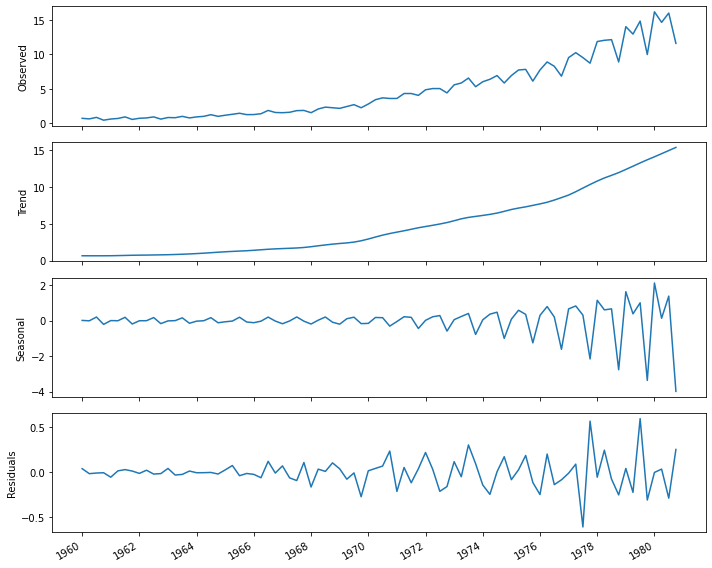

In [6]:
fig,  (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
# First model the dataset using an ARIMA(p,d,q) model
# Test for stationerity using agugented Dickey Fuller algorithm

ADF_result = adfuller(df['data'])

print(f"ADF Statistic : {ADF_result[0]}")
print(f"P-value : {ADF_result[1]}")

ADF Statistic : 2.7420165734574766
P-value : 1.0


In [8]:
# The process is not statitionery, so we apply differentiation to make it stationery (p-value is greater than 0.05..)
df_diff = np.diff(df['data'], n=1)

In [9]:
ADF_result = adfuller(df_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'P-value: {ADF_result[1]}')

ADF Statistic: -0.4074097636380437
P-value: 0.9088542416911309


In [10]:
# The process is still not statitionery, so we apply differentiation again
df_diff2 = np.diff(df_diff, n=1)

In [11]:
ADF_result = adfuller(df_diff2)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'P-value: {ADF_result[1]}')

ADF Statistic: -3.5851628747931694
P-value: 0.006051099869603393


In [12]:
# We have a p-value smaller than 0.05 and a large negative ADF statistic, our series is stationary
# d = 2 (Number of rounds of differencing to make our data stationery)
d = 2

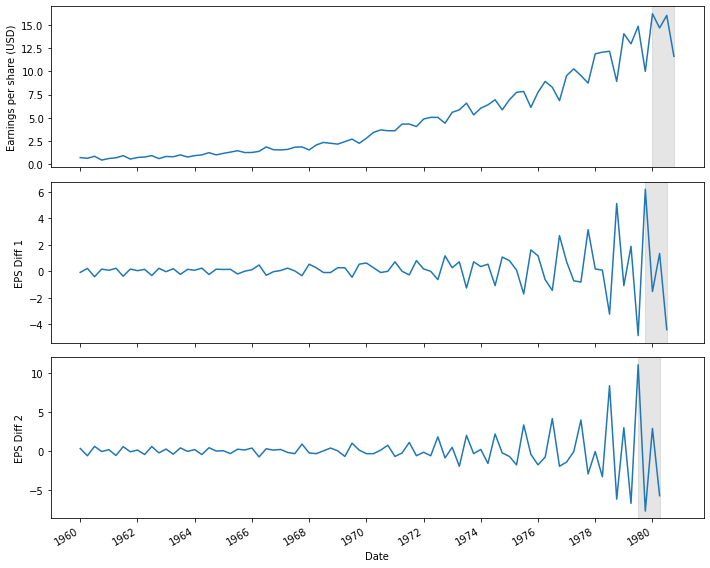

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(df['data'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Earnings per share (USD)')
ax1.axvspan(80, 83, color="#808080", alpha=0.2)

ax2.plot(df_diff)
ax2.set_xlabel('Date')
ax2.set_ylabel('EPS Diff 1')
ax2.axvspan(79, 82, color="#808080", alpha=0.2)

ax3.plot(df_diff2)
ax3.set_xlabel('Date')
ax3.set_ylabel('EPS Diff 2')
ax3.axvspan(78, 81, color="#808080", alpha=0.2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [14]:
# We define a list of possible values for the orders p and q.

from itertools import product

# Allow p and q to vary from 0 to 4 in order to capture seasonal information
ps = range(0, 5, 1)
qs = range(0, 5, 1)

# Set P and Q to 0, since we are working with an ARIMA(p,d,q) model
Ps = [0]
Qs = [0]

# D is set to 0 because we are working with an ARIMA(p,d,q) model
D = 0

# The parameter s is equivalent to m. They both denote the frequency. 
# This is simply how the SARIMA model is implemented in the statsmodels library
s = 4

# Generate all possible combinations of (p,d,q)(0,0,0)
ARIMA_order_list = list(product(ps, qs, Ps, Qs))
print(ARIMA_order_list)

[(0, 0, 0, 0), (0, 1, 0, 0), (0, 2, 0, 0), (0, 3, 0, 0), (0, 4, 0, 0), (1, 0, 0, 0), (1, 1, 0, 0), (1, 2, 0, 0), (1, 3, 0, 0), (1, 4, 0, 0), (2, 0, 0, 0), (2, 1, 0, 0), (2, 2, 0, 0), (2, 3, 0, 0), (2, 4, 0, 0), (3, 0, 0, 0), (3, 1, 0, 0), (3, 2, 0, 0), (3, 3, 0, 0), (3, 4, 0, 0), (4, 0, 0, 0), (4, 1, 0, 0), (4, 2, 0, 0), (4, 3, 0, 0), (4, 4, 0, 0)]


In [15]:
# use optimize_ARIMA function to fit the many ARIMA(p,d,q) models

from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []

    # Iterate over each unique (p,q,P,Q) combination. The use of tqdm will display a progress bar
    for order in tqdm(order_list):
        try:
            # Fit an ARIMA(p,d,q) model using the SARIMAX function.
            # We specify simple_differencing=False, to prevent differencing.
            # We also specify disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog, 
                            order=(order[0], d, order[1]), 
                            seasonal_order = (order[2], D, order[3], s),
                            simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [16]:
# Run the optimize_SARIMA function to obtain the model with the lowest AIC -> Akaike Information Criterion.
import warnings
warnings.filterwarnings('ignore')

train = df['data'][:-4].copy()
test = df['data'][-4:].copy()

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(4, 4, 0, 0)",111.879570
1,"(3, 4, 0, 0)",112.421809
2,"(4, 1, 0, 0)",114.496645
3,"(4, 2, 0, 0)",114.905229
4,"(3, 3, 0, 0)",115.270277
5,"(4, 0, 0, 0)",115.528651
6,"(3, 1, 0, 0)",115.624980
7,"(3, 2, 0, 0)",115.672007
8,"(4, 3, 0, 0)",119.663048
9,"(3, 0, 0, 0)",154.430646


In [17]:
# From the returned DataFrame, a SARIMA(4,2,4)(0,0,0)4 model seems to be the most suitable, so fit it on the training set
# Note a SARIMA(4,2,4)(0,0,0) is equivalent to ARIMA(4,2,4)

ARIMA_model = SARIMAX(train, order=(4, 2, 4), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

residuals = ARIMA_model_fit.resid

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(4, 2, 4)   Log Likelihood                 -46.940
Date:                Thu, 05 Oct 2023   AIC                            111.880
Time:                        12:53:42   BIC                            133.090
Sample:                             0   HQIC                           120.370
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6576      0.413     -4.011      0.000      -2.468      -0.848
ar.L2         -1.6635      0.447     -3.719      0.000      -2.540      -0.787
ar.L3         -1.6210      0.430     -3.768      0.0

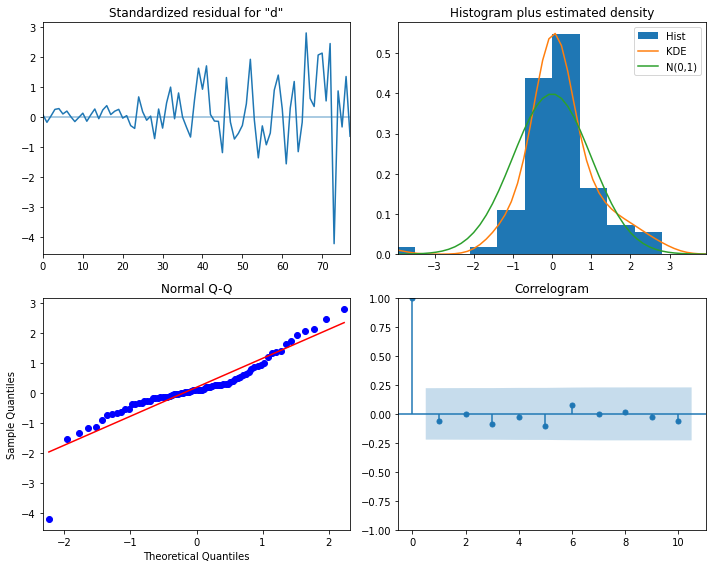

In [18]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

In [19]:
# From the the top-left plot, the variance is not constant, which is a discrepancy in comparison to white noise. 
# At the top right is the distribution of the residuals, we can see what is close to a normal distribution. 
# The Q-Q plot displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. 
# Finally, the correlogram at the bottom right, shows no significant coefficients after lag 0, just like white noise.

# Thus, from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, 
# as it means that the model’s errors are random.

In [20]:
# Next run the Ljung-Box test on the residuals to make sure that they are independent and uncorrelated
from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df = True)
lbvalue.columns = ['stat', 'p-value']
lbvalue

,stat,p-value
1,0.883028,0.347374
2,0.954946,0.620349
3,1.844550,0.605289
4,1.913704,0.751627
5,2.789029,0.732472
6,3.336827,0.765537
7,3.337161,0.852160
8,3.354287,0.910200
9,3.413369,0.945633
10,3.749001,0.957960


In [21]:
# Because all the p-values are greater than 0.05, reject the null hypothesis with a 5% chance of being wrong
# Residuals are uncorelated. We proceed with using the ARIMA model for forecasting, so that we can compare it to SARIMA

In [22]:
test = pd.DataFrame(test)
test.head()

,data
80,16.20
81,14.67
82,16.02
83,11.61


In [23]:
# The naive seasonal forecast reuses the data from 1979 as a forecast for 1980
test['naive_seasonal'] = df['data'].iloc[75:79].values

In [24]:
# Get ARIMA predictions for each quarter of 1980
ARIMA_pred = ARIMA_model_fit.get_prediction(79, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test.head()

,data,naive_seasonal,ARIMA_pred
80,16.20,8.91,16.075053
81,14.67,14.04,14.291811
82,16.02,12.96,16.562453
83,11.61,14.85,11.723265


In [25]:
# Forecasting with a SARIMA(p,d,q)(P,D,Q)m model
# Note: Unlike in ARIMA, after applying differentiation to get df_diff and failing to get a stationary process, 
# we resort to Seasonal differencing. Since we have quarterly data, m = 4,
# the seasonal difference is the difference between two values that are 4 timesteps apart.

df_diff_seasonal_diff = np.diff(df_diff, n=4)

adf_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {adf_result[0]}')
print(f'P-value: {adf_result[1]}')

ADF Statistic: -6.032499262653189
P-value: 1.4070571055428187e-07


In [26]:
# With a large and negative ADF statistic and a p-value smaller than 0.05, we can reject the null hypothesis and 
# consider the transformed series as stationary
# Note: we have done one round of differencing, d=1 and one round of seasonal differencing, D=1
d = 1
D = 1
s = 4

In [27]:
# Next define the range of possible values for p, q, P, and Q
# We try values of [0,1,2,3] for p, q, P, and Q.

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

# Generate the unique combinations of orders
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
#print(SARIMA_order_list)

In [28]:
train = df['data'][:-4].copy()

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(3, 0, 2, 1)",88.835093
1,"(1, 2, 0, 0)",89.609996
2,"(3, 1, 0, 0)",89.677549
3,"(1, 3, 0, 0)",89.734025
4,"(2, 2, 0, 0)",90.178107
...,...,...
251,"(0, 0, 3, 2)",136.749198
252,"(0, 0, 2, 3)",136.768610
253,"(0, 0, 0, 0)",137.133568
254,"(0, 0, 1, 3)",137.761947


In [29]:
# From the returned DataFrame, a SARIMA(3,1,0)(2,1,1)4 model seems to be the most suitable, so fit it on the training set

SARIMA_model = SARIMAX(train, order=(3, 1, 0), seasonal_order=(2, 1, 1, 4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
residuals = SARIMA_model_fit.resid

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                data   No. Observations:                   80
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 4)   Log Likelihood                 -37.418
Date:                             Thu, 05 Oct 2023   AIC                             88.835
Time:                                     13:02:11   BIC                            105.058
Sample:                                          0   HQIC                            95.313
                                              - 80                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8267      0.115     -7.214      0.000      -1.051      -0.602
ar.L2         -0.3756      

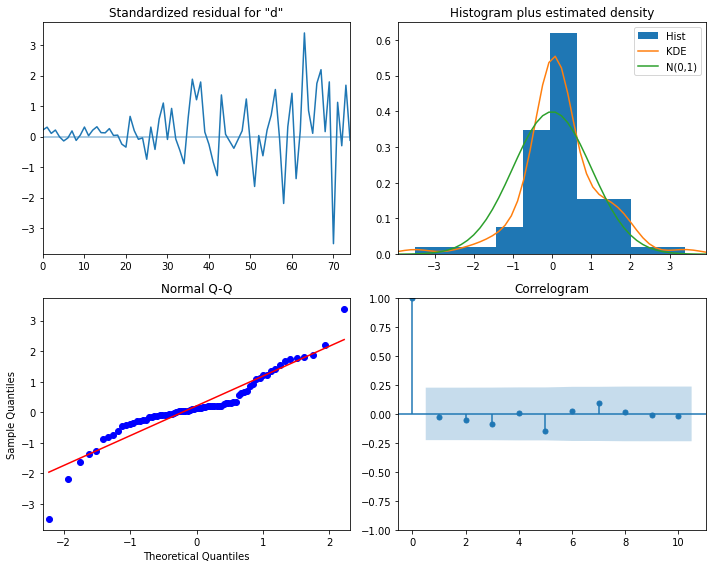

In [30]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

In [31]:
# From the the top-left plot, the variance is not constant, which is a discrepancy in comparison to white noise. 
# At the top right is the distribution of the residuals, we can see what is close to a normal distribution. 
# The Q-Q plot displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. 
# Finally, the correlogram at the bottom right, shows no significant coefficients after lag 0, just like white noise.

# Thus, from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, 
# as it means that the model’s errors are random.

In [32]:
# Next run the Ljung-Box test on the residuals to make sure that they are independent and uncorrelated

from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df = True)
lbvalue.columns = ['stat', 'p-value']
lbvalue

,stat,p-value
1,0.070788,0.790192
2,0.208220,0.901126
3,1.090955,0.779258
4,1.107214,0.893126
5,2.766971,0.735858
6,2.869754,0.825008
7,3.735087,0.809734
8,3.769881,0.877266
9,3.782839,0.925115
10,3.807137,0.955628


In [33]:
# p-values are all > 0.05, so we can conclude that the residuals are independent/uncorrelated like white noise.
# We now use it for forcasting

SARIMA_pred = SARIMA_model_fit.get_prediction(79, 83).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

test.head()

,data,naive_seasonal,ARIMA_pred,SARIMA_pred
80,16.20,8.91,16.075053,16.527093
81,14.67,14.04,14.291811,14.094839
82,16.02,12.96,16.562453,17.283817
83,11.61,14.85,11.723265,11.367144


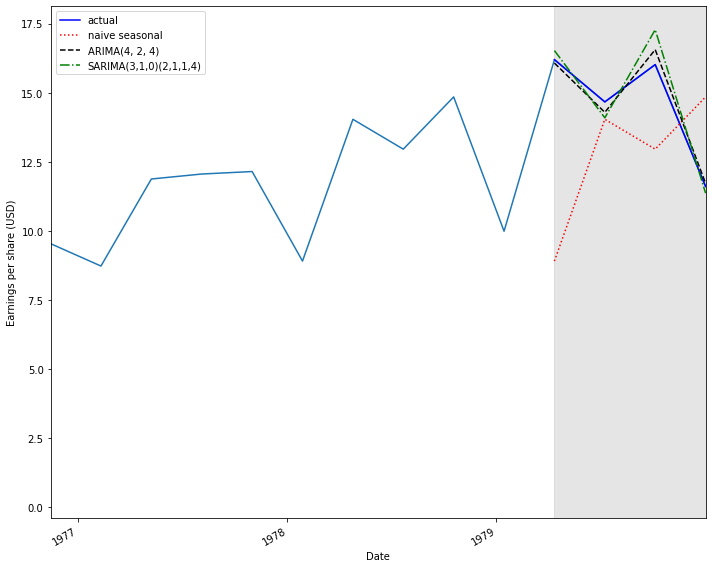

In [34]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(4, 2, 4)')
ax.plot(test['SARIMA_pred'], 'g-.', label = 'SARIMA(3,1,0)(2,1,1,4)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

#plt.xticks(np.arange(0, 84, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
plt.xticks(np.arange(0, 83, 4.15), np.arange(1960, 1980, 1))
ax.set_xlim(70, 83)

fig.autofmt_xdate()
plt.tight_layout()

In [35]:
# function to compute the  MAPE - Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
# Calculate MAPE
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

24.07564471682476 1.9277330566913986 3.9801322591149164


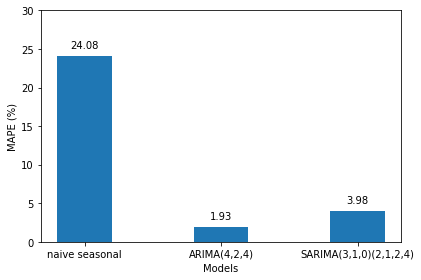

In [37]:
# Plot the MAPE
x = ['naive seasonal', 'ARIMA(4,2,4)', 'SARIMA(3,1,0)(2,1,2,4)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

fig, ax = plt.subplots()

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 30)

# display the MAPE as text in the bar plot
for index, value in enumerate(y):
    plt.text(x=index, y=value+1, s=str(round(value, 2)), ha='center')
    
plt.tight_layout()

In [38]:
# the ARIMA model has the lowest MAPE of all methods and is therefore the best-performing method for this situation

In [39]:
# Record end time

end = dt.now()
elapsed = end - start

print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:09:09
